# Contraceptive Method Choice

In [1]:
import os
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

## Import dataset

**original dataset info**

   1. Wife's age                     (numerical)
   2. Wife's education               (categorical)      1=low, 2, 3, 4=high
   3. Husband's education            (categorical)      1=low, 2, 3, 4=high
   4. Number of children ever born   (numerical)
   5. Wife's religion                (binary)           0=Non-Islam, 1=Islam
   6. Wife's now working?            (binary)           0=Yes, 1=No
   7. Husband's occupation           (categorical)      1, 2, 3, 4
   8. Standard-of-living index       (categorical)      1=low, 2, 3, 4=high
   9. Media exposure                 (binary)           0=Good, 1=Not good
   10. Contraceptive method used     (class attribute)  1=No-use, 2=Long-term, 3=Short-term **<=**
   
**_Notes_**
- Column #10 is to be predicted.
- I'm going to change columns names and invert some of the values, as they don't correspond to common notation (e.g. #5,6,9)

In [2]:
path_to_data_set = os.path.join("UCI_datasets", "cmc", "cmc.data")

names = {
    "W_AGE"                  : 'int8',
    "W_EDU"                  : 'category',
    "H_EDU"                  : 'category',
    "NUM_CHILDREN"           : 'int8',
    "W_ISLAM"                : 'bool',
    "W_WORKING"              : 'bool',
    "H_JOB"                  : 'category',
    "SOL"                    : 'category',
    "BAD_MEDIA"              : 'bool',
    "CONT_USAGE"             : 'category'
}

table = pd.read_table(path_to_data_set, delimiter=",",  
                      header=None, index_col=False, 
                      names=names.keys(),
                      dtype=names,
                      engine='python'
                     )

In [3]:
table.head()

,W_AGE,W_EDU,H_EDU,NUM_CHILDREN,W_ISLAM,W_WORKING,H_JOB,SOL,BAD_MEDIA,CONT_USAGE
0,24,2,3,3,True,True,2,3,False,1
1,45,1,3,10,True,True,3,4,False,1
2,43,2,3,7,True,True,3,4,False,1
3,42,3,2,9,True,True,3,3,False,1
4,36,3,3,8,True,True,3,2,False,1


inverting values of columns

In [4]:
table["W_WORKING"] = table["W_WORKING"].apply(lambda x: not x)
# table["W_ISLAM"] = table["W_ISLAM"].apply(lambda x: not x)

### Data visualization

#### Unique values

In [5]:
for x in table.columns:
    print(x)
    print(table[x].unique())

W_AGE
[24 45 43 42 36 19 38 21 27 44 26 48 39 37 46 40 29 31 33 25 28 47 32 49
 34 20 22 30 23 35 41 17 18 16]
W_EDU
[2, 1, 3, 4]
Categories (4, object): [2, 1, 3, 4]
H_EDU
[3, 2, 4, 1]
Categories (4, object): [3, 2, 4, 1]
NUM_CHILDREN
[ 3 10  7  9  8  0  6  1  2  4  5 12 11 13 16]
W_ISLAM
[ True False]
W_WORKING
[False  True]
H_JOB
[2, 3, 1, 4]
Categories (4, object): [2, 3, 1, 4]
SOL
[3, 4, 2, 1]
Categories (4, object): [3, 4, 2, 1]
BAD_MEDIA
[False  True]
CONT_USAGE
[1, 2, 3]
Categories (3, object): [1, 2, 3]


#### Correlation matrix
It's only available for numeric values, but still worthy to have a look

In [6]:
corr_matrix = table.corr().round(2)

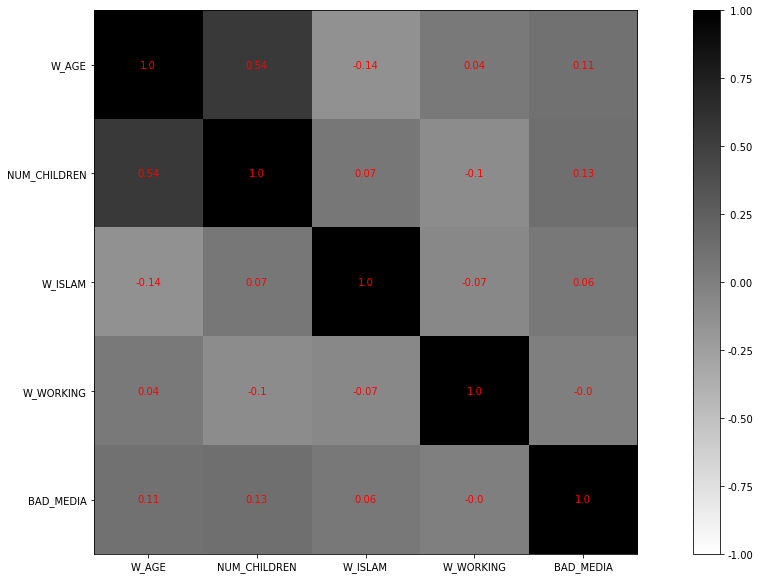

In [7]:
ig, ax = plt.subplots(figsize=(10,10))
ig.set_figwidth(20)

im = ax.imshow(corr_matrix, cmap='binary', interpolation='nearest')
im.set_clim(-1, 1)
ax.grid(False)
cols = ["",'W_AGE', 'NUM_CHILDREN', 'W_ISLAM', 'W_WORKING', 'BAD_MEDIA']

ax.set_xticklabels(cols)
ax.set_yticklabels(cols)

for i in range(5):
    for j in range(5):
        ax.text(j, i, corr_matrix.iloc[i, j], ha='center', va='center', color='r')
        

cbar = ax.figure.colorbar(im, ax=ax, format='% .2f')
plt.show()

Wife's Age histogram

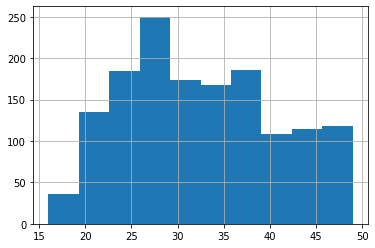

In [8]:
table['W_AGE'].hist()

 1. No-use
 2. Long-term
 3. Short-term 

Exploring number of values in each category
1. No-use"
2. Long-term
3. Short-term 

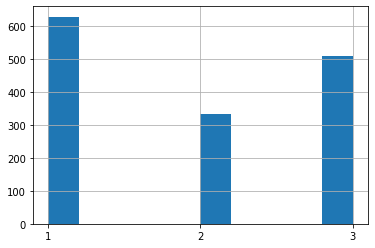

In [9]:
table['CONT_USAGE'].hist()

#### Bucketing(binning) values

To produce better results in training I'll bucket continuous variable in to discrete chunks.

Let's first explore histogram, to have a rough understanding of how many records we have in each age category

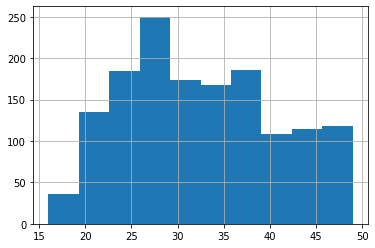

In [10]:
table['W_AGE'].hist()

Lets bucket in 4 different ranges, to make it more balanced the following ranges are chosen (pretty close to percentiles):

`[0, 25], (25, 32], (32, 40], (40, 50]`

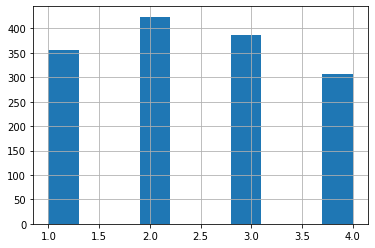

In [11]:
bins = [0, 25, 32, 40, 50]
labels = [1,2,3,4]

table['W_AGE_binned'] = pd.cut(table['W_AGE'], bins=bins, labels=labels)
# table = table.astype({'W_AGE_binned' : 'category'})
table['W_AGE_binned'].hist()
table.drop(columns=['W_AGE'], inplace=True)

Now is the time to bucket another discrete valued column. Let's look at number of unique values

In [12]:
table['NUM_CHILDREN'].value_counts()

2     276
1     276
3     259
4     197
5     135
0      97
6      92
7      49
8      47
9      16
11     11
10     11
12      4
13      2
16      1
Name: NUM_CHILDREN, dtype: int64

Due to bucketing limitations, I'll change all 0s to -1s, so .cut() can still be used

In [13]:
table["NUM_CHILDREN"] = table["NUM_CHILDREN"].apply(lambda x: -1 if x == 0 else x)

The here I'm going to bucket values according to the real world perspective

`[0], [1], [2, 3], [3, 5], [5+]`

So we can distinguish families without kids from families with kids, and small families from bigger families. This approach might be usefull for a more extensive research.

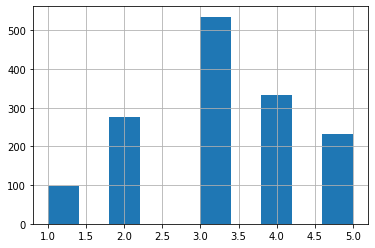

In [14]:
bins = [-2, 0, 1, 3, 5, 20]
labels = [1,2,3,4, 5]


table['NUM_CHILDREN_binned'] = pd.cut(table['NUM_CHILDREN'], bins=bins, labels=labels)
# table = table.astype({'W_AGE_binned' : 'category'})
table['NUM_CHILDREN_binned'].hist()
table.drop(columns=['NUM_CHILDREN'], inplace=True)

In [15]:
table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1473 entries, 0 to 1472
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   W_EDU                1473 non-null   category
 1   H_EDU                1473 non-null   category
 2   W_ISLAM              1473 non-null   bool    
 3   W_WORKING            1473 non-null   bool    
 4   H_JOB                1473 non-null   category
 5   SOL                  1473 non-null   category
 6   BAD_MEDIA            1473 non-null   bool    
 7   CONT_USAGE           1473 non-null   category
 8   W_AGE_binned         1473 non-null   category
 9   NUM_CHILDREN_binned  1473 non-null   category
dtypes: bool(3), category(7)
memory usage: 15.7 KB


In [16]:
X = table.drop(columns=['CONT_USAGE'], inplace=False)
y = table['CONT_USAGE'].copy()

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

## Train model

importing libraries

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression



from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import tree

In [18]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

------
Checking for prediction to work at all

In [19]:
some_row = X.iloc[1].copy()
knn_clf.predict([some_row])

array(['1'], dtype=object)

In [20]:
y.loc[1]

'1'

----
back to other model training

### KNN with GridSearchCV

`GridsearchCV` for the best arguments for model

In [41]:
from sklearn.decomposition import KernelPCA
from sklearn.pipeline import Pipeline

In [55]:
param_grid = {
    'n_neighbors': range(25, 50),
    'p': [1, 2],
    'leaf_size': range(2, 20) 
}

grid_search_knn = GridSearchCV(knn_clf, param_grid, cv=3)
grid_search_knn.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'leaf_size': range(2, 20),
                         'n_neighbors': range(25, 50), 'p': [1, 2]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [56]:
print(grid_search_knn.best_params_)

{'leaf_size': 4, 'n_neighbors': 48, 'p': 1}


In [57]:
grid_search_knn.best_score_

0.544724029388929

### A lot of classifiers with basic arguments

In [21]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="rbf", C=0.025, probability=True),
    NuSVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis()]

# Logging for Visual Comparison
log_cols=["Classifier", "Accuracy", "Log Loss"]
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    print("="*30, '\n')
    print(name)
    
    print('****Results****')
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    print("Accuracy: {:.4%}".format(acc))
    
    train_predictions = clf.predict_proba(X_test)
    ll = log_loss(y_test, train_predictions)
    print("Log Loss: {}".format(ll))
    
    log_entry = pd.DataFrame([[name, acc*100, ll]], columns=log_cols)
    log = log.append(log_entry)
    
print("="*30)


KNeighborsClassifier
****Results****
Accuracy: 49.7738%
Log Loss: 7.378527328645

SVC
****Results****
Accuracy: 41.6290%
Log Loss: 0.9268706185731129

NuSVC
****Results****
Accuracy: 53.3937%
Log Loss: 0.9731195868826773

DecisionTreeClassifier
****Results****
Accuracy: 45.7014%
Log Loss: 13.840482842316408

RandomForestClassifier
****Results****
Accuracy: 54.2986%
Log Loss: 1.561853828016383

AdaBoostClassifier
****Results****
Accuracy: 55.2036%
Log Loss: 1.076262224924683

GradientBoostingClassifier
****Results****
Accuracy: 57.9186%
Log Loss: 0.951867629144146

GaussianNB
****Results****
Accuracy: 47.9638%
Log Loss: 1.5379714750043765

LinearDiscriminantAnalysis
****Results****
Accuracy: 53.8462%
Log Loss: 0.9352166516944005

QuadraticDiscriminantAnalysis
****Results****
Accuracy: 52.0362%
Log Loss: 1.4083156808514656


In [24]:
from sklearn.decomposition import PCA

In [25]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [26]:
d

7

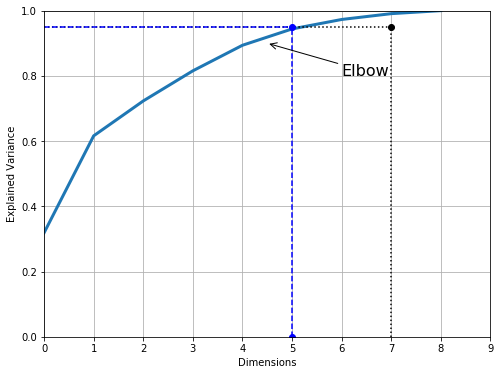

In [49]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 9, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")


plt.plot([5, 5], [0, 0.95], marker='o', color='b', linestyle="--")
plt.plot([0, 5], [0.95, 0.95],color='b', linestyle="--")

plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(4.5, 0.9), xytext=(6, 0.8),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
plt.show()

## Model evaluation 

### Comparing trained models

`macro` is necessary for multilable classifiers

In [16]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.model_selection import cross_val_predict

def metrics(clf, X, Y, t_x, t_y):
    pred = cross_val_predict(clf, X, Y, cv=3)
    y_pred = clf.predict(t_x)
    
    print('Accuracy on test set: {}'.format(accuracy_score(t_y, y_pred)))
    print('F1: {}'.format(f1_score(Y, pred, average="macro")))
    print('Precision: {}'.format(precision_score(Y, pred, average="macro")))
    print('Recall: {}'.format(recall_score(Y, pred, average="macro")))

### ROC curves

In [17]:


def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)                                            

In [18]:
from sklearn.metrics import roc_curve

plt.figure(figsize=(8, 6))

knn_y_scores = cross_val_predict(knn_clf1, X_train, y_train, cv=3)
fpr, tpr, thresholds = roc_curve(y_train, knn_y_scores)
plot_roc_curve(fpr, tpr, label='KNN')

gnb_y_scores = cross_val_predict(gnb_clf1, X_train, y_train, cv=3)
fpr, tpr, thresholds = roc_curve(y_train, gnb_y_scores)
plot_roc_curve(fpr, tpr, label='Bayesian')

tree_y_scores = cross_val_predict(tree_clf1, X_train, y_train, cv=3)
fpr, tpr, thresholds = roc_curve(y_train, tree_y_scores)
plot_roc_curve(fpr, tpr, label='Tree')

plt.legend(loc="lower right", fontsize=16)

plt.show()

NameError: name 'knn_clf1' is not defined

<Figure size 576x432 with 0 Axes>

from sklearn.metrics import roc_curve

plt.figure(figsize=(8, 6))

knn_y_scores = cross_val_predict(knn_clf1, X_train, y_train, cv=3)
fpr, tpr, thresholds = roc_curve(y_train, knn_y_scores)
plot_roc_curve(fpr, tpr, label='KNN')

gnb_y_scores = cross_val_predict(gnb_clf1, X_train, y_train, cv=3)
fpr, tpr, thresholds = roc_curve(y_train, gnb_y_scores)
plot_roc_curve(fpr, tpr, label='Bayesian')

tree_y_scores = cross_val_predict(tree_clf1, X_train, y_train, cv=3)
fpr, tpr, thresholds = roc_curve(y_train, tree_y_scores)
plot_roc_curve(fpr, tpr, label='Tree')

plt.legend(loc="lower right", fontsize=16)

plt.show()

### Comparing trained models

`macro` is necessary for multilable classifiers

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.model_selection import cross_val_predict

def metrics(clf, X, Y, t_x, t_y):
    pred = cross_val_predict(clf, X, Y, cv=3)
    y_pred = clf.predict(t_x)
    
    print('Accuracy on test set: {}'.format(accuracy_score(t_y, y_pred)))
    print('F1: {}'.format(f1_score(Y, pred, average="macro")))
    print('Precision: {}'.format(precision_score(Y, pred, average="macro")))
    print('Recall: {}'.format(recall_score(Y, pred, average="macro")))

### ROC curves

In [ ]:


def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)                                            

In [ ]:
from sklearn.metrics import roc_curve

plt.figure(figsize=(8, 6))

knn_y_scores = cross_val_predict(knn_clf1, X_train, y_train, cv=3)
fpr, tpr, thresholds = roc_curve(y_train, knn_y_scores)
plot_roc_curve(fpr, tpr, label='KNN')

gnb_y_scores = cross_val_predict(gnb_clf1, X_train, y_train, cv=3)
fpr, tpr, thresholds = roc_curve(y_train, gnb_y_scores)
plot_roc_curve(fpr, tpr, label='Bayesian')

tree_y_scores = cross_val_predict(tree_clf1, X_train, y_train, cv=3)
fpr, tpr, thresholds = roc_curve(y_train, tree_y_scores)
plot_roc_curve(fpr, tpr, label='Tree')

plt.legend(loc="lower right", fontsize=16)

plt.show()